Mesh Variables
======

Underworld solves finite element variables, such as temperature and pressure fields, on a spatial grid called a mesh. The data for these fields is stored in finite element variables which are solved on the mesh using underworld. How to use the meshes was the topic of the previous user guide, here we continue on from there by looking at the finite element variables themselves.

**This notebook is broken down into the following examples:**
1. setting up mesh variables on a mesh
2. setting initial conditons on mesh variables
3. gradients of mesh variable fields
3. loading and saving mesh variable data
4. remeshing data onto different mesh sizes

**Keywords:** mesh variables, finite elements, load/save, initial conditions

In [1]:
import underworld as uw
import glucifer
import math

Creating a MeshVariable
-----

Create a 4 $\times$ 4 element mesh object. For more information on **the mesh** see the user guide.

In [2]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                 elementRes  = (4, 4), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (1., 1.) )

**Create a mesh variable**

Create a mesh variable for the temperature field using the ``mesh`` object. Note that since the temperature has a single value at each point in space then it has a single degree of freedom, so the last parameter in the command below is set to one.

In [3]:
temperatureField = uw.meshvariable.MeshVariable( mesh=mesh, nodeDofCount=1 )

Set initial conditions on the MeshVariable
-----

The temperature field has now been created and associated with a mesh object. Now we can assign values at each grid point. To set or change the data for a variable the following command may be used

    temperatureField.data[index] = value

where ``value`` can be a number or (more likely) a function and ``index`` refers to the mesh node point number.

**Example 1: Index**

To give an idea of what the mesh index means, we will plot the index as a colour in space.

In [4]:
for index, coord in enumerate(mesh.data):
    temperatureField.data[index] = index


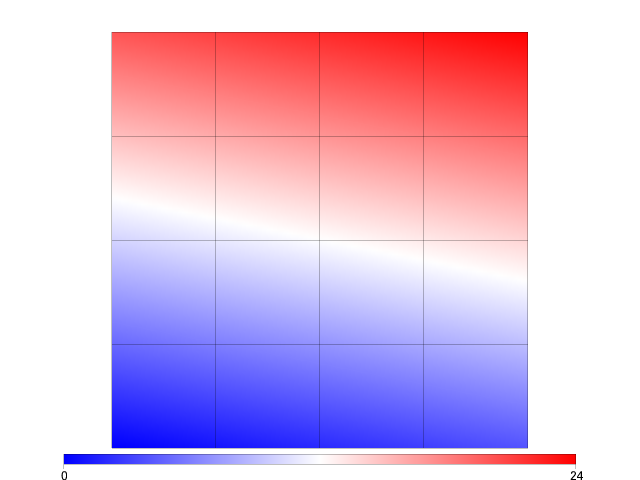

In [5]:
fig = glucifer.Figure()
fig + glucifer.objects.Surface( mesh, temperatureField, colours = 'blue white red' )
fig + glucifer.objects.Mesh( mesh )
fig.show()

The mesh point index increases from zero at the bottom left, to the right first and then the next line. We can also see this if we print out the values of the first ``res`` mesh points.

In [6]:
res = mesh.elementRes[0]
print('Resolution = {0:3d}'.format(res))
# the enumerate function outputs the mesh index and spatial coordinate data for each mesh node point
for index, coord in enumerate(mesh.data):
    if(index<2*(res+1)):
        print('T = {0:1.0f}; x = {1:.3f}, z = {2:.3f}'.format(temperatureField.data[index][0], coord[0], coord[1]))

Resolution =   4
T = 0; x = 0.000, z = 0.000
T = 1; x = 0.250, z = 0.000
T = 2; x = 0.500, z = 0.000
T = 3; x = 0.750, z = 0.000
T = 4; x = 1.000, z = 0.000
T = 5; x = 0.000, z = 0.250
T = 6; x = 0.250, z = 0.250
T = 7; x = 0.500, z = 0.250
T = 8; x = 0.750, z = 0.250
T = 9; x = 1.000, z = 0.250


The first output is the temperature value (also the mesh index number), the second is the ``x`` value of the mesh point and the third is the ``z`` value.
There will be the first two lines of x values output, each will be the resolution number + 1. For example a resolution of 4 will lead to 5 values in the x direction since there are 4 cells and this mesh is defined using the cell edges. The figure above also demonstrates this.

**Examlpe 2: Single point**

Here we will set the temperature to be zero everywhere, except a single value set to one in the centre.

In [7]:
# set every point to zero
temperatureField.data[...] = 0.0
# find the mid point
midPoint = int(len(temperatureField.data)/2.0)
# set the temperature at the mid point to one
temperatureField.data[midPoint] = 1.0

Plot resulting temperature field


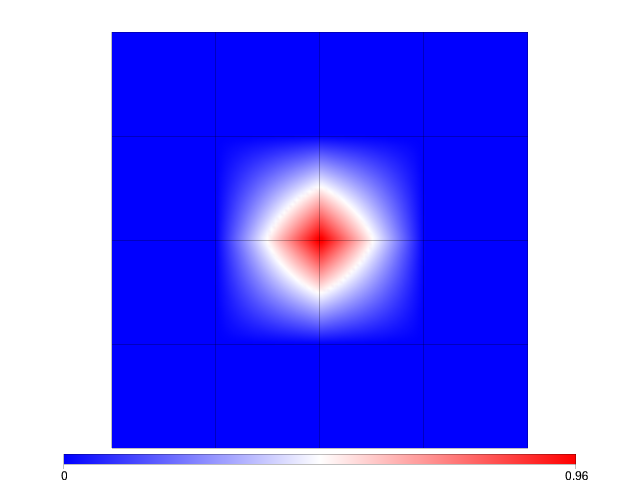

In [8]:
fig = glucifer.Figure()
fig + glucifer.objects.Surface( mesh, temperatureField, colours = 'blue white red' )
fig + glucifer.objects.Mesh( mesh )
fig.show()

Note that the plotting software used by underworld (``gLucifer``) interpolates between the mesh node points inside each cell. Thus the single non-zero point will have a gradient around in when plotted.

**Example 3: Smooth function**

Initialise the temperature variable with a function based on its spatial coordinates
\\[
T = x \left( 1 - z \right)
\\]

In [9]:
for index, coord in enumerate(mesh.data):
    temperatureField.data[index] = coord[0] * (1.0 - coord[1])

Plot result


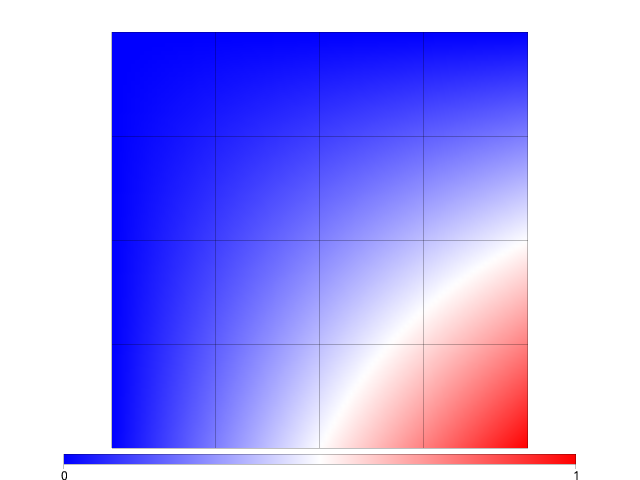

In [10]:
fig = glucifer.Figure()
fig + glucifer.objects.Surface( mesh, temperatureField, colours = 'blue white red' )
fig + glucifer.objects.Mesh( mesh )
fig.show()

**Example 4: Velocity field**

While a temperature field has a single value at each mesh point the velocity field will have as many values as there are dimensions in the model. In this example we will construct a velocity field for a two dimensional box.

**Create meshes and variables**

Note that the velocity field also uses the edges of each cell to define data values on, as in the temperature field case. The difference is in defining the velocit variable, in that there are ``dim`` degrees of freedom rather than just one.

In [11]:
dim = 2
boxHeight = 1.0
boxLength = 1.0
res = 64
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                 elementRes  = (res, res), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (boxLength, boxHeight) )
temperatureField = uw.meshvariable.MeshVariable( mesh=mesh, nodeDofCount=1 )
velocityField    = uw.meshvariable.MeshVariable( mesh=mesh, nodeDofCount=dim )

**Set initial condtions for velocity and temperature**

Set the temperature to a simple gradient $T = (1 - z)$, while the velocity is set to

$$
    \mathbf{v} = \sin(x \pi) \sin(y \pi) \left( z - z_{mid}, x - x_{mid} \right)
$$

where $mid$ denotes the middle of the box.

In [12]:
coordmid = (0.5, 0.5)
for index, coord in enumerate(mesh.data):
    mag = math.sin( coord[0]*(math.pi) )*math.sin( coord[1]*(math.pi) )
    vx = -mag * (coord[1]-coordmid[1])
    vy =  mag * (coord[0]-coordmid[0])
    velocityField.data[index] = (vx, vy)
    temperatureField.data[index] = 1 - coord[1]


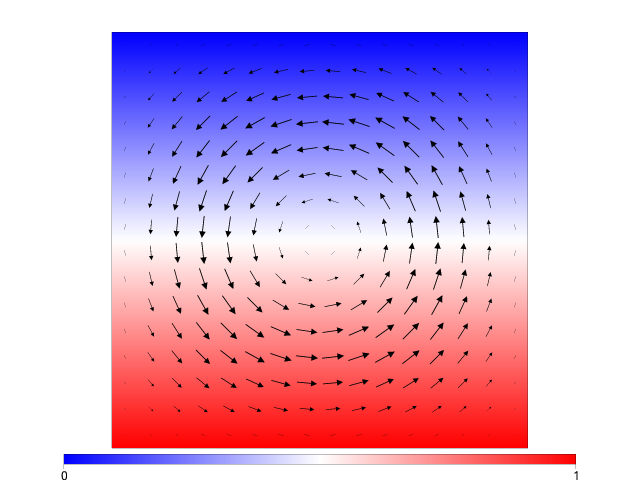

In [13]:
fig = glucifer.Figure()
fig + glucifer.objects.Surface( mesh, temperatureField, colours = 'blue white red' )
fig + glucifer.objects.VectorArrows( mesh, velocityField, lengthScale=1., arrowHeadSize=0.2 )
fig.show()

Gradients of mesh variables
-----

The gradient of the field is accessible via the ``gradientFn`` attribute:

In [14]:
gradTemp = temperatureField.gradientFn

As expected the vertical gradient of the temperature field $T = (1-z)$ is a constant.


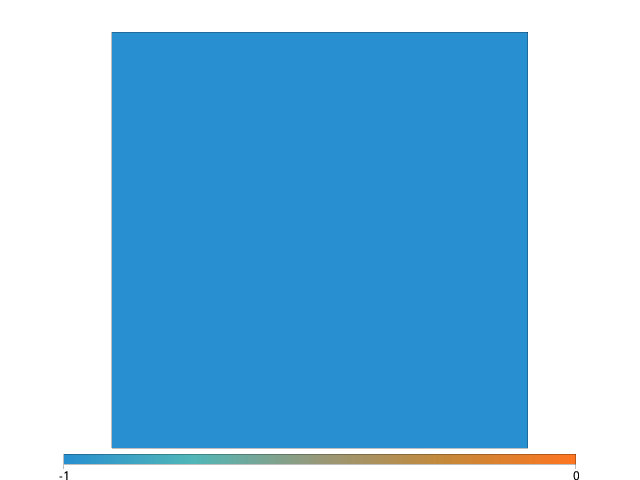

In [15]:
figGrad = glucifer.Figure()
figGrad + glucifer.objects.Surface( mesh, gradTemp[1] )
figGrad.show()

Loading and saving variables
------

In this example we will use the previous initial conditions for the temperature field, save them to file, reset them, and then recover the original data by loading from file.

**Set directory paths**

Set the directory paths for the input and output files to be stored in. These must be specified relative to the current directory (``user_guide``).

In [16]:
dirPath = 'LoadSave/'

**Quickly setup a new mesh and temperature variable.**

In [17]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                 elementRes  = (64, 64), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (1., 1.) )
temperatureField = uw.meshvariable.MeshVariable( mesh=mesh, nodeDofCount=1 )

**Set some initial conditions for the variable.**

In [18]:
for index, coord in enumerate(mesh.data):
    temperatureField.data[index] = coord[0] * (1.0 - coord[1])

**Plot initial temperature field**


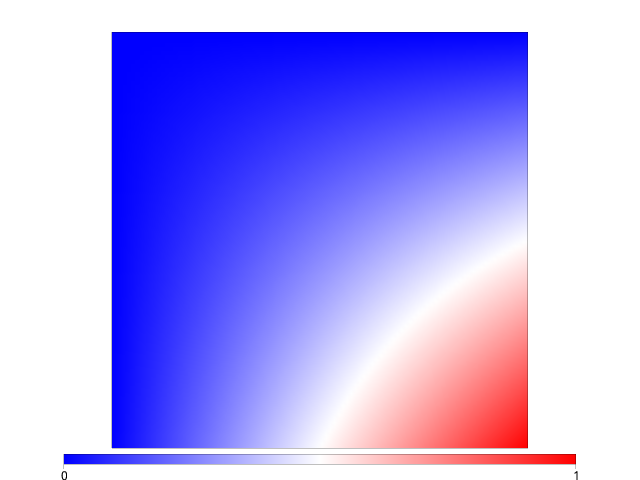

In [19]:
fig = glucifer.Figure()
fig + glucifer.objects.Surface( mesh, temperatureField, colours = 'blue white red' )
fig.show()

**Save temperature field to file in local directory**

Underworld has built in functions for saving and loading variables to files. The file format is ``hdf5`` which is typically given the ``.h5`` file extension. For more information on ``hdf5`` see [here](https://en.wikipedia.org/wiki/Hierarchical_Data_Format#HDF5) and regarding ``hdf5`` in python see [here](http://www.h5py.org/).

In [20]:
temperatureField.save(dirPath+'MeshVariableSaveExample.h5')

**Potential error**: sometimes it will not be able to create the file, since the directory does not exist. Make sure to check your hard disk as well as the ``dirPath`` parameter set above.

**Change temperature field data and re-plot**

Having save the temperature data, now we will over write it.

In [21]:
for index, coord in enumerate(mesh.data):
    temperatureField.data[index] = float(index)


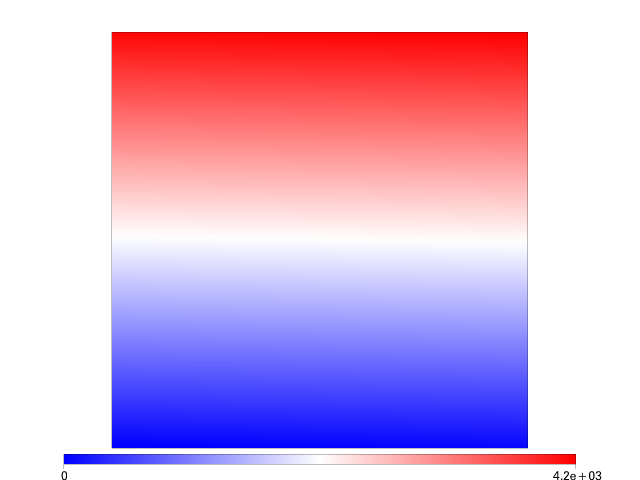

In [22]:
fig = glucifer.Figure()
fig + glucifer.objects.Surface( mesh, temperatureField, colours = 'blue white red' )
fig.show()

**Reload from file and plot saved temperature field**

Now we will load the variable from the file we saved above. This will overwrite the data we just put in.

In [23]:
temperatureField.load(dirPath+'MeshVariableSaveExample.h5')

**Potential error**: make sure that this has the same filename as previously.


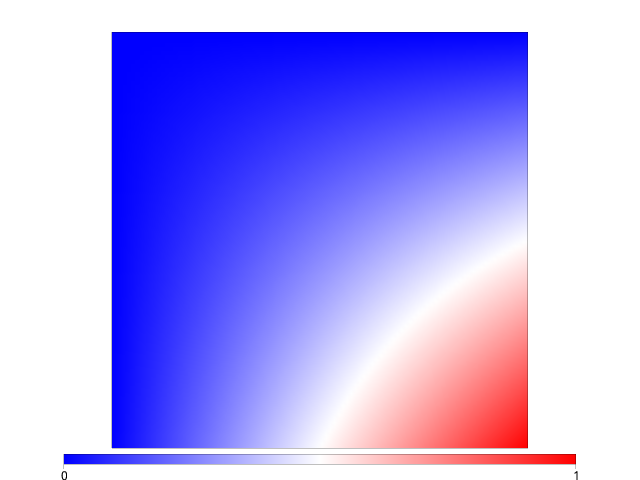

In [24]:
fig = glucifer.Figure()
fig + glucifer.objects.Surface( mesh, temperatureField, colours = 'blue white red' )
fig.show()

Remeshing data
------

To demonstrate what can be done with meshes this example will change the resolution of a set of initial conditions to a lower resolution. 

**Generate some data on high resolution mesh**

Here we set the simulation box height and length as well as the resolutions to use later. 

The parameter *res* gives the resolution for the saved (to file) data, while *newres* is the resampled resolution.

In this case we will generate input on a mesh that is $128\times128$ and remap it down to a low resolution mesh. Mapping up in resolution is just a case of changing the value of *newres*.


Create the high resolution mesh for FE variable

In [25]:
res = 128
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                 elementRes  = (res, res), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (1., 1.))

Create temperature initial conditions that will not map well to low resolution.

In [26]:
temperatureField = uw.meshvariable.MeshVariable( mesh=mesh, nodeDofCount=1 )
numberSin = 20.0
for index, coord in enumerate(mesh.data):
    phase = math.pi * numberSin * coord[0]/boxLength + 10.0 * coord[1]
    temperatureField.data[index] = math.cos( phase )

Plot high resolution temperature field


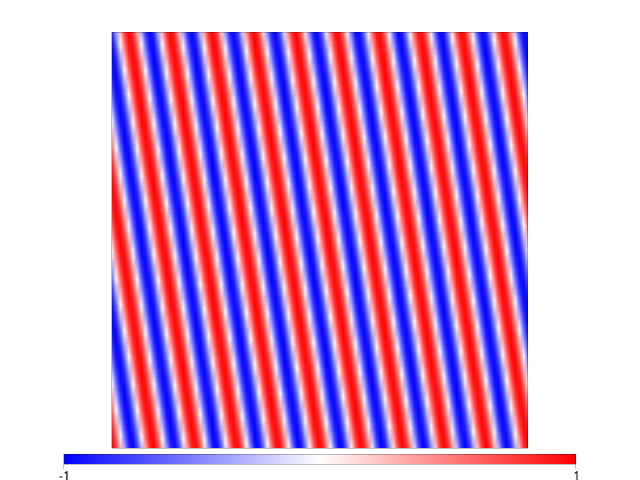

In [27]:
fig = glucifer.Figure()
fig + glucifer.objects.Surface( mesh, temperatureField, colours = 'blue white red' )
fig.show()

**Remesh initial conditions**

Remesh temperature field onto a new resolution. Mesh resolution set by *newres* variable defined below.

In [28]:
newres = 16
meshNew = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                    elementRes  = (newres, newres), 
                                    minCoord    = (0., 0.), 
                                    maxCoord    = (1., 1.))
print('Remeshing from a square grid of {0:3d} mesh points to {1:3d} mesh points'.format(res, newres))

Remeshing from a square grid of 128 mesh points to  16 mesh points


Create new variable for the new temperature field on the new mesh.

In [29]:
temperatureFieldNew = uw.meshvariable.MeshVariable( mesh=meshNew, nodeDofCount=1 )

**Re-map values**

Re-map values from original temperature field data onto the new temperature field with the new mesh.

The line below passes the new mesh information, contained in *linearMeshnew*, into the evaluate function contained in the *temperatureField* structure. What this does is then evaluate the temperature value at each point in the new linear mesh. These values are then copied into the new temperature field data values, stored in *temperatureFieldnew*.

In [30]:
temperatureFieldNew.data[:] = temperatureField.evaluate(meshNew)

**Plot remeshed temperature fields**

This plot will look identical to the previous temperature plot for sufficiently high resolution. However, mapping the temperature values onto low resolution noticably causes a loss of the details compared to the original figure.


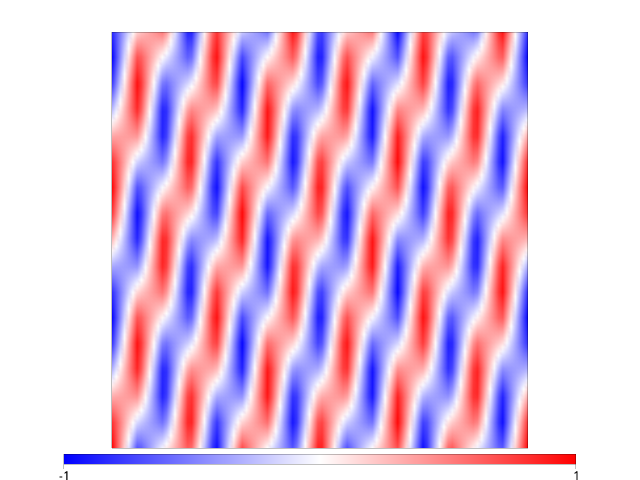

In [31]:
fig = glucifer.Figure()
fig + glucifer.objects.Surface( meshNew, temperatureFieldNew, colours = 'blue white red' )
fig.show()

**So what else has changed?**

Since the temperature field is remapped onto a new mesh, the values in space change if the mesh is sufficiently different, in addition the way they are stored has changed a lot. 

Firstly the size of the data arrays has changed from 129$^2$ (0-128 mesh points in a square grid) to 9$^2$. Secondly the exact data stored on a given index has changed. For example, say T[10] = 0.50 on the original mesh, but after re-meshing the index 10 might now refer to a value on the boundary of the new mesh, which might now give T[10] = 0. 

Both of these are demonstrated below.

In [32]:
print 'Old temperature field data size was {0:3d}^2'.format(int(math.sqrt(len(temperatureField.data))))
print 'New temperature field data size is  {0:3d}^2'.format(int(math.sqrt(len(temperatureFieldNew.data))))

Old temperature field data size was 129^2
New temperature field data size is   17^2


In [33]:
if(res < newres):
    testpoint = int(res*res / 2)
    print 'Mid point of original mesh in original then new temperature variable:'
else:
    testpoint = int(newres*newres / 2)
    print 'Mid point of new (smaller) mesh in original then new temperature variable:'

# note that the [0] at the end retreves the value from the truple.
oldValue = temperatureField.data[testpoint][0]
newValue = temperatureFieldNew.data[testpoint][0]
print '  T_old({0:4d}) = {1:.3f}'.format(testpoint,oldValue)
print '  T_new({0:4d}) = {1:.3f}'.format(testpoint,newValue)

Mid point of new (smaller) mesh in original then new temperature variable:
  T_old( 128) = 1.000
  T_new( 128) = -0.433


These values will typically be different, depending on the actual values in the temperature field.

In [ ]:
# cleanup
import os; if uw.rank()==0: os.remove("MeshVariableSaveExample.h5")